In [8]:
# # Abalone Age Prediction - ML Modeling Pipeline

# This notebook contains the complete machine learning pipeline for predicting abalone age from physical measurements.

# ## Objective
# Build a robust ML pipeline with:
# - Data preprocessing functions
# - Model training with Random Forest
# - Comprehensive evaluation metrics
# - Prediction pipeline for new data

# **Target**: Predict the number of rings (age indicator) from physical measurements

In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from typing import Tuple, Dict, Any, Optional

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
import joblib

# Configure plotting and warnings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (12, 8)

print("🤖 Abalone Age Prediction - ML Pipeline")
print("=" * 50)

🤖 Abalone Age Prediction - ML Pipeline


## 1. Data Loading and Inspection Functions

In [10]:
def load_data(file_path: str) -> pd.DataFrame:
    """
    Load the abalone dataset and perform basic validation.
    
    Args:
        file_path (str): Path to the CSV file
        
    Returns:
        pd.DataFrame: Loaded dataset
    """
    print("📂 Loading dataset...")
    
    try:
        df = pd.read_csv(file_path)
        print(f"✅ Dataset loaded successfully: {df.shape[0]} rows, {df.shape[1]} columns")
        
        # Basic validation
        expected_columns = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 
                          'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']
        
        if list(df.columns) != expected_columns:
            print("⚠️  Warning: Column names don't match expected format")
            print(f"Found columns: {list(df.columns)}")
            
        return df
        
    except FileNotFoundError:
        print(f"❌ Error: File not found at {file_path}")
        raise
    except Exception as e:
        print(f"❌ Error loading data: {str(e)}")
        raise

def inspect_data(df: pd.DataFrame) -> Dict[str, Any]:
    """
    Perform comprehensive data inspection.
    
    Args:
        df (pd.DataFrame): Dataset to inspect
        
    Returns:
        Dict[str, Any]: Inspection summary
    """
    print("\n🔍 Data Inspection Report")
    print("=" * 30)
    
    inspection = {}
    
    # Basic info
    inspection['shape'] = df.shape
    inspection['memory_usage'] = df.memory_usage(deep=True).sum() / 1024**2  # MB
    
    # Missing values
    missing = df.isnull().sum()
    inspection['missing_values'] = missing[missing > 0].to_dict()
    
    # Duplicates
    inspection['duplicates'] = df.duplicated().sum()
    
    # Data types
    inspection['dtypes'] = df.dtypes.to_dict()
    
    # Basic statistics for numerical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    inspection['numerical_summary'] = df[numerical_cols].describe().to_dict()
    
    # Categorical columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    inspection['categorical_summary'] = {}
    
    for col in categorical_cols:
        inspection['categorical_summary'][col] = {
            'unique_values': df[col].unique().tolist(),
            'value_counts': df[col].value_counts().to_dict()
        }
    
    # Print summary
    print(f"📊 Shape: {inspection['shape']}")
    print(f"💾 Memory usage: {inspection['memory_usage']:.2f} MB")
    print(f"❓ Missing values: {len(inspection['missing_values'])} columns affected")
    print(f"🔄 Duplicate rows: {inspection['duplicates']}")
    
    if inspection['missing_values']:
        print("Missing data details:")
        for col, count in inspection['missing_values'].items():
            print(f"  - {col}: {count} missing")
    
    return inspection

# Load and inspect the data
df = load_data('../data/abalone.csv')
data_inspection = inspect_data(df)

# Display first few rows
print("\n📋 First 5 rows:")
display(df.head())

📂 Loading dataset...
✅ Dataset loaded successfully: 4177 rows, 9 columns

🔍 Data Inspection Report
📊 Shape: (4177, 9)
💾 Memory usage: 0.45 MB
❓ Missing values: 0 columns affected
🔄 Duplicate rows: 0

📋 First 5 rows:


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


## 2. Data Preprocessing Pipeline

In [11]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean the dataset by handling missing values and outliers.
    
    Args:
        df (pd.DataFrame): Raw dataset
        
    Returns:
        pd.DataFrame: Cleaned dataset
    """
    print("\n🧹 Cleaning data...")
    
    df_clean = df.copy()
    original_size = len(df_clean)
    
    # Remove rows with missing values (if any)
    if df_clean.isnull().any().any():
        df_clean = df_clean.dropna()
        print(f"   Removed {original_size - len(df_clean)} rows with missing values")
    
    # Remove duplicate rows
    duplicates = df_clean.duplicated().sum()
    if duplicates > 0:
        df_clean = df_clean.drop_duplicates()
        print(f"   Removed {duplicates} duplicate rows")
    
    # Handle outliers using IQR method for key features
    numerical_cols = ['Length', 'Diameter', 'Height', 'Whole weight', 
                     'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']
    
    outliers_removed = 0
    for col in numerical_cols:
        if col in df_clean.columns:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
            outliers_removed += len(outliers)
            
            # Remove extreme outliers (beyond 3 IQR)
            extreme_lower = Q1 - 3 * IQR
            extreme_upper = Q3 + 3 * IQR
            df_clean = df_clean[(df_clean[col] >= extreme_lower) & (df_clean[col] <= extreme_upper)]
    
    print(f"   Final dataset size: {len(df_clean)} rows ({original_size - len(df_clean)} removed)")
    
    return df_clean

def encode_categorical_features(df: pd.DataFrame, fit_encoders: bool = True, 
                               encoders: Dict = None) -> Tuple[pd.DataFrame, Dict]:
    """
    Encode categorical features using appropriate encoding methods.
    
    Args:
        df (pd.DataFrame): Dataset with categorical features
        fit_encoders (bool): Whether to fit new encoders or use existing ones
        encoders (Dict): Pre-fitted encoders (if fit_encoders=False)
        
    Returns:
        Tuple[pd.DataFrame, Dict]: Encoded dataset and fitted encoders
    """
    print("\n🏷️  Encoding categorical features...")
    
    df_encoded = df.copy()
    
    if fit_encoders:
        encoders = {}
        
        # Encode Sex column (M, F, I)
        if 'Sex' in df_encoded.columns:
            le_sex = LabelEncoder()
            df_encoded['Sex_encoded'] = le_sex.fit_transform(df_encoded['Sex'])
            encoders['Sex'] = le_sex
            
            # Create dummy variables for better model performance
            sex_dummies = pd.get_dummies(df_encoded['Sex'], prefix='Sex')
            df_encoded = pd.concat([df_encoded, sex_dummies], axis=1)
            
            # Drop original Sex column
            df_encoded = df_encoded.drop('Sex', axis=1)
            
            print(f"   Encoded 'Sex' column: {le_sex.classes_}")
    
    else:
        # Use existing encoders
        if 'Sex' in df_encoded.columns and 'Sex' in encoders:
            df_encoded['Sex_encoded'] = encoders['Sex'].transform(df_encoded['Sex'])
            
            # Create dummy variables
            sex_dummies = pd.get_dummies(df_encoded['Sex'], prefix='Sex')
            df_encoded = pd.concat([df_encoded, sex_dummies], axis=1)
            df_encoded = df_encoded.drop('Sex', axis=1)
    
    return df_encoded, encoders

def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create additional features that might improve model performance.
    
    Args:
        df (pd.DataFrame): Dataset with encoded features
        
    Returns:
        pd.DataFrame: Dataset with engineered features
    """
    print("\n🔧 Engineering features...")
    
    df_features = df.copy()
    
    # Create ratio features that might be predictive
    if all(col in df_features.columns for col in ['Shucked weight', 'Whole weight']):
        # Avoid division by zero and handle small values
        whole_weight_safe = df_features['Whole weight'].replace(0, np.nan)
        df_features['Shucked_to_Whole_ratio'] = (
            df_features['Shucked weight'] / whole_weight_safe
        ).fillna(0).replace([np.inf, -np.inf], 0).clip(0, 10)  # Cap extreme values
    
    if all(col in df_features.columns for col in ['Shell weight', 'Whole weight']):
        whole_weight_safe = df_features['Whole weight'].replace(0, np.nan)
        df_features['Shell_to_Whole_ratio'] = (
            df_features['Shell weight'] / whole_weight_safe
        ).fillna(0).replace([np.inf, -np.inf], 0).clip(0, 10)  # Cap extreme values
    
    if all(col in df_features.columns for col in ['Length', 'Diameter']):
        diameter_safe = df_features['Diameter'].replace(0, np.nan)
        df_features['Length_to_Diameter_ratio'] = (
            df_features['Length'] / diameter_safe
        ).fillna(0).replace([np.inf, -np.inf], 0).clip(0, 10)  # Cap extreme values
    
    # Create volume approximation (Length * Diameter * Height)
    if all(col in df_features.columns for col in ['Length', 'Diameter', 'Height']):
        df_features['Volume_approx'] = (
            df_features['Length'] * df_features['Diameter'] * df_features['Height']
        ).replace([np.inf, -np.inf], 0).fillna(0)
    
    # Create density approximation (Weight / Volume)
    if all(col in df_features.columns for col in ['Whole weight', 'Volume_approx']):
        volume_safe = df_features['Volume_approx'].replace(0, np.nan)
        df_features['Density_approx'] = (
            df_features['Whole weight'] / volume_safe
        ).fillna(0).replace([np.inf, -np.inf], 0).clip(0, 1000)  # Cap extreme density values
    
    # Check for and handle any remaining infinite or extremely large values
    for col in df_features.select_dtypes(include=[np.number]).columns:
        # Replace infinite values with 0
        df_features[col] = df_features[col].replace([np.inf, -np.inf], 0)
        # Cap extremely large values (greater than 1e6)
        df_features[col] = df_features[col].clip(-1e6, 1e6)
        # Fill any remaining NaN values with 0
        df_features[col] = df_features[col].fillna(0)
    
    print(f"   Created {len(df_features.columns) - len(df.columns)} new features")
    print(f"   All infinite and extreme values handled safely")
    
    return df_features

def scale_features(X: pd.DataFrame, fit_scaler: bool = True, 
                  scaler: StandardScaler = None) -> Tuple[pd.DataFrame, StandardScaler]:
    """
    Scale numerical features using StandardScaler.
    
    Args:
        X (pd.DataFrame): Features to scale
        fit_scaler (bool): Whether to fit a new scaler or use existing one
        scaler (StandardScaler): Pre-fitted scaler (if fit_scaler=False)
        
    Returns:
        Tuple[pd.DataFrame, StandardScaler]: Scaled features and fitted scaler
    """
    print("\n📏 Scaling features...")
    
    # Safety check for infinite or extremely large values before scaling
    X_safe = X.copy()
    
    # Only work with numerical columns
    numerical_cols = X_safe.select_dtypes(include=[np.number]).columns
    non_numerical_cols = X_safe.select_dtypes(exclude=[np.number]).columns
    
    if len(non_numerical_cols) > 0:
        print(f"   Warning: Non-numerical columns found: {list(non_numerical_cols)}")
        print("   These columns will be excluded from scaling")
    
    # Check for and handle problematic values in numerical columns only
    for col in numerical_cols:
        # Replace infinite values
        X_safe[col] = X_safe[col].replace([np.inf, -np.inf], np.nan)
        
        # Fill NaN values with median
        if X_safe[col].isnull().any():
            median_val = X_safe[col].median()
            if pd.isna(median_val):  # If all values are NaN, use 0
                median_val = 0
            X_safe[col] = X_safe[col].fillna(median_val)
        
        # Cap extremely large values
        X_safe[col] = X_safe[col].clip(-1e6, 1e6)
    
    # Verify no infinite or NaN values remain in numerical columns
    numerical_data = X_safe[numerical_cols]
    if len(numerical_cols) > 0:
        if np.any(np.isinf(numerical_data.values)) or np.any(np.isnan(numerical_data.values)):
            print("   Warning: Found remaining infinite or NaN values, fixing...")
            X_safe[numerical_cols] = X_safe[numerical_cols].fillna(0).replace([np.inf, -np.inf], 0)
    
    # Only scale numerical columns
    if len(numerical_cols) == 0:
        print("   Warning: No numerical columns found for scaling!")
        return X_safe, scaler
    
    # Extract numerical data for scaling
    X_numerical = X_safe[numerical_cols]
    
    if fit_scaler:
        scaler = StandardScaler()
        X_scaled_numerical = scaler.fit_transform(X_numerical)
    else:
        X_scaled_numerical = scaler.transform(X_numerical)
    
    # Convert back to DataFrame to preserve column names
    X_scaled_df = pd.DataFrame(X_scaled_numerical, columns=numerical_cols, index=X.index)
    
    # Add back any non-numerical columns (unchanged)
    for col in non_numerical_cols:
        X_scaled_df[col] = X_safe[col]
    
    # Reorder columns to match original order
    X_scaled_df = X_scaled_df[X.columns]
    
    print(f"   Scaled {len(numerical_cols)} numerical features safely")
    if len(non_numerical_cols) > 0:
        print(f"   Kept {len(non_numerical_cols)} non-numerical features unchanged")
    
    return X_scaled_df, scaler

# Apply preprocessing to the loaded data
print("\n" + "="*50)
print("🔄 PREPROCESSING PIPELINE")
print("="*50)

# Clean the data
df_clean = clean_data(df)

# Encode categorical features
df_encoded, encoders = encode_categorical_features(df_clean)

# Engineer features
df_features = feature_engineering(df_encoded)

print(f"\n✅ Preprocessing complete!")
print(f"   Original columns: {len(df.columns)}")
print(f"   Final columns: {len(df_features.columns)}")
print(f"   Final dataset shape: {df_features.shape}")

# Display the processed data
print("\n📋 Processed data sample:")
display(df_features.head())


🔄 PREPROCESSING PIPELINE

🧹 Cleaning data...
   Final dataset size: 4136 rows (41 removed)

🏷️  Encoding categorical features...
   Encoded 'Sex' column: ['F' 'I' 'M']

🔧 Engineering features...
   Created 5 new features
   All infinite and extreme values handled safely

✅ Preprocessing complete!
   Original columns: 9
   Final columns: 17
   Final dataset shape: (4136, 17)

📋 Processed data sample:


,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_encoded,Sex_F,Sex_I,Sex_M,Shucked_to_Whole_ratio,Shell_to_Whole_ratio,Length_to_Diameter_ratio,Volume_approx,Density_approx
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,2,False,False,True,0.436770,0.291829,1.246575,0.015777,32.578813
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,2,False,False,True,0.441242,0.310421,1.320755,0.008347,27.014076
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0,True,False,False,0.378877,0.310192,1.261905,0.030051,22.528368
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,2,False,False,True,0.417636,0.300388,1.205479,0.020075,25.703611
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,1,False,True,False,0.436585,0.268293,1.294118,0.006732,30.451575


## 3. Data Splitting Functions

In [12]:
def prepare_features_target(df: pd.DataFrame, target_column: str = 'Rings') -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separate features and target variable.
    
    Args:
        df (pd.DataFrame): Processed dataset
        target_column (str): Name of the target column
        
    Returns:
        Tuple[pd.DataFrame, pd.Series]: Features and target
    """
    print(f"\n🎯 Preparing features and target ('{target_column}')...")
    
    if target_column not in df.columns:
        raise ValueError(f"Target column '{target_column}' not found in dataset")
    
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    print(f"   Features shape: {X.shape}")
    print(f"   Target shape: {y.shape}")
    print(f"   Target range: {y.min()} - {y.max()}")
    
    return X, y

def split_data(X: pd.DataFrame, y: pd.Series, 
              test_size: float = 0.2, 
              random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """
    Split data into training and testing sets.
    
    Args:
        X (pd.DataFrame): Features
        y (pd.Series): Target variable
        test_size (float): Proportion of data for testing
        random_state (int): Random seed for reproducibility
        
    Returns:
        Tuple: X_train, X_test, y_train, y_test
    """
    print(f"\n📊 Splitting data (test_size={test_size})...")
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        random_state=random_state,
        stratify=None  # No stratification for regression
    )
    
    print(f"   Training set: {X_train.shape[0]} samples")
    print(f"   Test set: {X_test.shape[0]} samples")
    print(f"   Training target range: {y_train.min()} - {y_train.max()}")
    print(f"   Test target range: {y_test.min()} - {y_test.max()}")
    
    return X_train, X_test, y_train, y_test

# Prepare features and target
X, y = prepare_features_target(df_features, 'Rings')

# Split the data
X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.2, random_state=42)

# Scale the features
X_train_scaled, feature_scaler = scale_features(X_train, fit_scaler=True)
X_test_scaled, _ = scale_features(X_test, fit_scaler=False, scaler=feature_scaler)

print(f"\n✅ Data preparation complete!")
print(f"   Training features: {X_train_scaled.shape}")
print(f"   Test features: {X_test_scaled.shape}")


🎯 Preparing features and target ('Rings')...
   Features shape: (4136, 16)
   Target shape: (4136,)
   Target range: 1 - 20

📊 Splitting data (test_size=0.2)...
   Training set: 3308 samples
   Test set: 828 samples
   Training target range: 1 - 20
   Test target range: 3 - 20

📏 Scaling features...
   These columns will be excluded from scaling
   Scaled 13 numerical features safely
   Kept 3 non-numerical features unchanged

📏 Scaling features...
   These columns will be excluded from scaling
   Scaled 13 numerical features safely
   Kept 3 non-numerical features unchanged

✅ Data preparation complete!
   Training features: (3308, 16)
   Test features: (828, 16)


## 4. Model Training Pipeline

In [13]:
def train_random_forest(X_train: pd.DataFrame, y_train: pd.Series,
                       hyperparameter_tuning: bool = True,
                       cv_folds: int = 5,
                       random_state: int = 42) -> Tuple[RandomForestRegressor, Dict]:
    """
    Train a Random Forest model with optional hyperparameter tuning.
    
    Args:
        X_train (pd.DataFrame): Training features
        y_train (pd.Series): Training target
        hyperparameter_tuning (bool): Whether to perform hyperparameter tuning
        cv_folds (int): Number of cross-validation folds
        random_state (int): Random seed
        
    Returns:
        Tuple[RandomForestRegressor, Dict]: Trained model and training info
    """
    print("\n🌲 Training Random Forest model...")
    
    training_info = {}
    
    if hyperparameter_tuning:
        print("   Performing hyperparameter tuning...")
        
        # Define parameter grid
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2']
        }
        
        # Create base model
        rf_base = RandomForestRegressor(random_state=random_state)
        
        # Perform grid search
        grid_search = GridSearchCV(
            rf_base, 
            param_grid, 
            cv=cv_folds,
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            verbose=1
        )
        
        grid_search.fit(X_train, y_train)
        
        # Get best model
        model = grid_search.best_estimator_
        training_info['best_params'] = grid_search.best_params_
        training_info['best_cv_score'] = -grid_search.best_score_
        training_info['cv_results'] = grid_search.cv_results_
        
        print(f"   Best parameters: {grid_search.best_params_}")
        print(f"   Best CV RMSE: {np.sqrt(-grid_search.best_score_):.4f}")
        
    else:
        print("   Training with default parameters...")
        
        # Use default parameters with some reasonable settings
        model = RandomForestRegressor(
            n_estimators=100,
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2,
            max_features='sqrt',
            random_state=random_state
        )
        
        model.fit(X_train, y_train)
        
        # Perform cross-validation to get performance estimate
        cv_scores = cross_val_score(
            model, X_train, y_train, 
            cv=cv_folds, 
            scoring='neg_mean_squared_error'
        )
        
        training_info['cv_scores'] = cv_scores
        training_info['mean_cv_score'] = -cv_scores.mean()
        training_info['std_cv_score'] = cv_scores.std()
        
        print(f"   CV RMSE: {np.sqrt(-cv_scores.mean()):.4f} (+/- {np.sqrt(cv_scores.std() * 2):.4f})")
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    training_info['feature_importance'] = feature_importance
    training_info['training_samples'] = len(X_train)
    training_info['n_features'] = X_train.shape[1]
    
    print(f"   Model trained successfully!")
    print(f"   Training samples: {len(X_train)}")
    print(f"   Features used: {X_train.shape[1]}")
    
    return model, training_info

def save_model_and_artifacts(model: RandomForestRegressor, 
                           scaler: StandardScaler,
                           encoders: Dict,
                           training_info: Dict,
                           model_dir: str = '../models') -> Dict[str, str]:
    """
    Save the trained model and all preprocessing artifacts.
    
    Args:
        model: Trained model
        scaler: Fitted feature scaler
        encoders: Fitted encoders
        training_info: Training information
        model_dir: Directory to save models
        
    Returns:
        Dict[str, str]: Paths where artifacts were saved
    """
    print(f"\n💾 Saving model and artifacts to '{model_dir}'...")
    
    # Create model directory if it doesn't exist
    Path(model_dir).mkdir(parents=True, exist_ok=True)
    
    paths = {}
    
    # Save model
    model_path = Path(model_dir) / 'random_forest_model.joblib'
    joblib.dump(model, model_path)
    paths['model'] = str(model_path)
    
    # Save scaler
    scaler_path = Path(model_dir) / 'feature_scaler.joblib'
    joblib.dump(scaler, scaler_path)
    paths['scaler'] = str(scaler_path)
    
    # Save encoders
    encoders_path = Path(model_dir) / 'encoders.joblib'
    joblib.dump(encoders, encoders_path)
    paths['encoders'] = str(encoders_path)
    
    # Save training info
    training_info_path = Path(model_dir) / 'training_info.joblib'
    joblib.dump(training_info, training_info_path)
    paths['training_info'] = str(training_info_path)
    
    print("   ✅ All artifacts saved successfully!")
    for artifact, path in paths.items():
        print(f"      {artifact}: {path}")
    
    return paths

# Train the model
print("\n" + "="*50)
print("🤖 MODEL TRAINING")
print("="*50)

# Train Random Forest with hyperparameter tuning
model, training_info = train_random_forest(
    X_train_scaled, y_train,
    hyperparameter_tuning=True,  # Set to False for faster training
    cv_folds=5,
    random_state=42
)

# Save model and artifacts
saved_paths = save_model_and_artifacts(
    model=model,
    scaler=feature_scaler,
    encoders=encoders,
    training_info=training_info,
    model_dir='../models'
)

# Display top feature importances
print(f"\n🔝 Top 10 Feature Importances:")
top_features = training_info['feature_importance'].head(10)
display(top_features)


🤖 MODEL TRAINING

🌲 Training Random Forest model...
   Performing hyperparameter tuning...
Fitting 5 folds for each of 162 candidates, totalling 810 fits
   Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
   Best CV RMSE: 1.9314
   Model trained successfully!
   Training samples: 3308
   Features used: 16

💾 Saving model and artifacts to '../models'...
   ✅ All artifacts saved successfully!
      model: ../models/random_forest_model.joblib
      scaler: ../models/feature_scaler.joblib
      encoders: ../models/encoders.joblib
      training_info: ../models/training_info.joblib

🔝 Top 10 Feature Importances:
   Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
   Best CV RMSE: 1.9314
   Model trained successfully!
   Training samples: 3308
   Features used: 16

💾 Saving model and artifacts to '../models'...
   ✅ All artifacts saved 

,feature,importance
6,Shell weight,0.178299
11,Shucked_to_Whole_ratio,0.157829
14,Volume_approx,0.114047
2,Height,0.093421
3,Whole weight,0.085114
5,Viscera weight,0.078374
12,Shell_to_Whole_ratio,0.070334
1,Diameter,0.057355
4,Shucked weight,0.046756
0,Length,0.036000


## 5. Model Evaluation Functions


📊 MODEL EVALUATION

📊 Evaluating model performance...
   Test Performance:
      RMSE: 1.9829
      MAE:  1.4156
      R²:   0.5907
   Training Performance:
      RMSE: 1.4446
      MAE:  1.0543
      R²:   0.7650
   Overfitting Analysis:
      RMSE difference: -0.5383
      R² difference:   0.1743

📈 Creating evaluation visualizations...


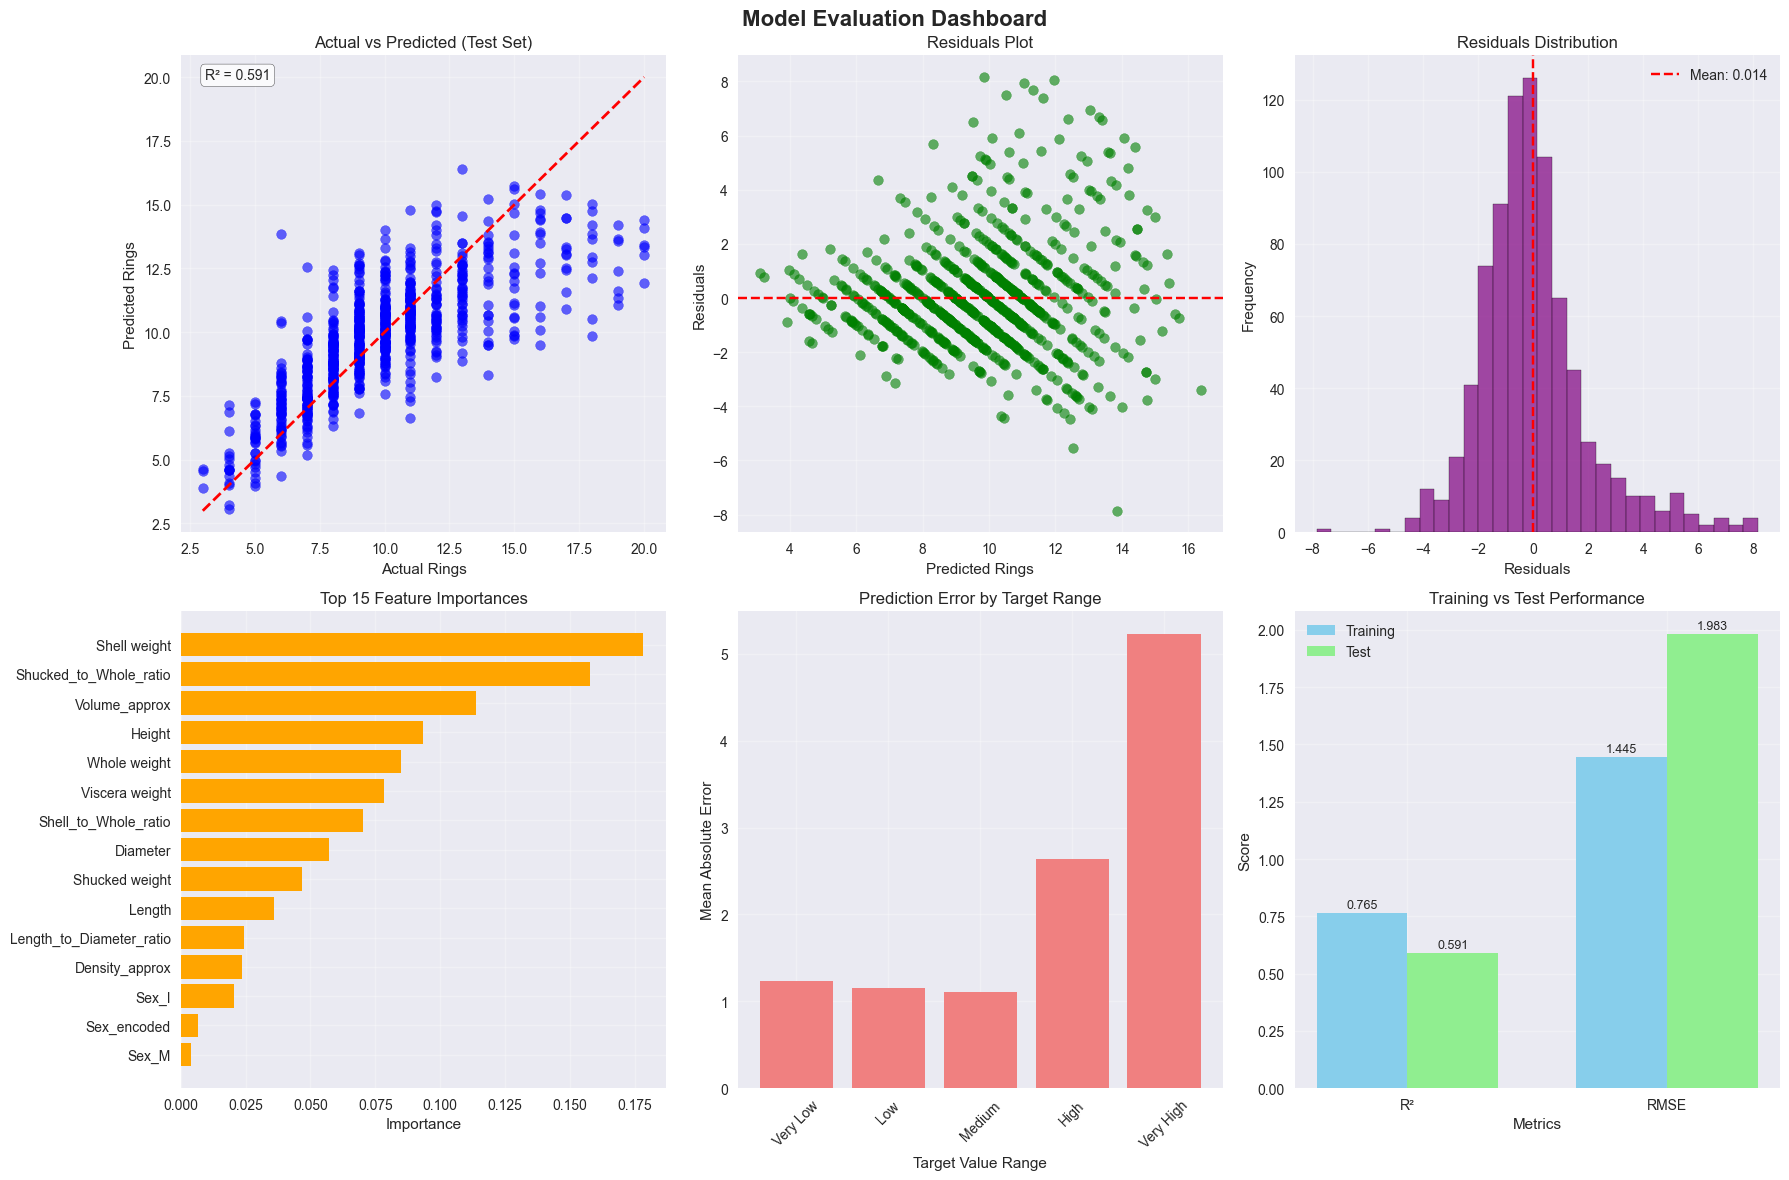


🔀 Calculating permutation feature importances...
   Calculated for 16 features

🔝 Top 10 Permutation Feature Importances:
   Calculated for 16 features

🔝 Top 10 Permutation Feature Importances:


,feature,importance_mean,importance_std
11,Shucked_to_Whole_ratio,1.282034,0.117324
6,Shell weight,1.069407,0.077856
14,Volume_approx,0.433446,0.051790
3,Whole weight,0.265770,0.042172
2,Height,0.223114,0.027466
12,Shell_to_Whole_ratio,0.128076,0.054575
9,Sex_I,0.112789,0.014081
5,Viscera weight,0.091945,0.024532
4,Shucked weight,0.062232,0.029883
1,Diameter,0.056583,0.018030


In [14]:
def evaluate_model(model: RandomForestRegressor, 
                  X_test: pd.DataFrame, 
                  y_test: pd.Series,
                  X_train: pd.DataFrame = None,
                  y_train: pd.Series = None) -> Dict[str, float]:
    """
    Evaluate model performance with comprehensive metrics.
    
    Args:
        model: Trained model
        X_test: Test features
        y_test: Test target
        X_train: Training features (optional, for training metrics)
        y_train: Training target (optional, for training metrics)
        
    Returns:
        Dict[str, float]: Evaluation metrics
    """
    print("\n📊 Evaluating model performance...")
    
    # Make predictions
    y_pred_test = model.predict(X_test)
    
    # Calculate test metrics
    test_metrics = {
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'test_mae': mean_absolute_error(y_test, y_pred_test),
        'test_r2': r2_score(y_test, y_pred_test)
    }
    
    # Calculate training metrics if training data provided
    if X_train is not None and y_train is not None:
        y_pred_train = model.predict(X_train)
        train_metrics = {
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred_train)),
            'train_mae': mean_absolute_error(y_train, y_pred_train),
            'train_r2': r2_score(y_train, y_pred_train)
        }
        test_metrics.update(train_metrics)
        
        # Calculate overfitting indicators
        test_metrics['overfitting_rmse'] = train_metrics['train_rmse'] - test_metrics['test_rmse']
        test_metrics['overfitting_r2'] = train_metrics['train_r2'] - test_metrics['test_r2']
    
    # Print results
    print("   Test Performance:")
    print(f"      RMSE: {test_metrics['test_rmse']:.4f}")
    print(f"      MAE:  {test_metrics['test_mae']:.4f}")
    print(f"      R²:   {test_metrics['test_r2']:.4f}")
    
    if 'train_rmse' in test_metrics:
        print("   Training Performance:")
        print(f"      RMSE: {test_metrics['train_rmse']:.4f}")
        print(f"      MAE:  {test_metrics['train_mae']:.4f}")
        print(f"      R²:   {test_metrics['train_r2']:.4f}")
        
        print("   Overfitting Analysis:")
        print(f"      RMSE difference: {test_metrics['overfitting_rmse']:.4f}")
        print(f"      R² difference:   {test_metrics['overfitting_r2']:.4f}")
    
    return test_metrics

def plot_evaluation_charts(model: RandomForestRegressor,
                          X_test: pd.DataFrame,
                          y_test: pd.Series,
                          X_train: pd.DataFrame = None,
                          y_train: pd.Series = None,
                          feature_names: list = None):
    """
    Create comprehensive evaluation visualizations.
    
    Args:
        model: Trained model
        X_test: Test features
        y_test: Test target
        X_train: Training features (optional)
        y_train: Training target (optional)
        feature_names: List of feature names for importance plot
    """
    print("\n📈 Creating evaluation visualizations...")
    
    # Make predictions
    y_pred_test = model.predict(X_test)
    
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Model Evaluation Dashboard', fontsize=16, fontweight='bold')
    
    # 1. Actual vs Predicted scatter plot
    axes[0, 0].scatter(y_test, y_pred_test, alpha=0.6, color='blue')
    axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[0, 0].set_xlabel('Actual Rings')
    axes[0, 0].set_ylabel('Predicted Rings')
    axes[0, 0].set_title('Actual vs Predicted (Test Set)')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add R² to the plot
    r2 = r2_score(y_test, y_pred_test)
    axes[0, 0].text(0.05, 0.95, f'R² = {r2:.3f}', transform=axes[0, 0].transAxes, 
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 2. Residuals plot
    residuals = y_test - y_pred_test
    axes[0, 1].scatter(y_pred_test, residuals, alpha=0.6, color='green')
    axes[0, 1].axhline(y=0, color='red', linestyle='--')
    axes[0, 1].set_xlabel('Predicted Rings')
    axes[0, 1].set_ylabel('Residuals')
    axes[0, 1].set_title('Residuals Plot')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Residuals histogram
    axes[0, 2].hist(residuals, bins=30, alpha=0.7, color='purple', edgecolor='black')
    axes[0, 2].axvline(residuals.mean(), color='red', linestyle='--', 
                      label=f'Mean: {residuals.mean():.3f}')
    axes[0, 2].set_xlabel('Residuals')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].set_title('Residuals Distribution')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Feature importance (top 15)
    if hasattr(model, 'feature_importances_'):
        feature_names = feature_names or [f'Feature_{i}' for i in range(len(model.feature_importances_))]
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=True).tail(15)
        
        axes[1, 0].barh(range(len(importance_df)), importance_df['importance'], color='orange')
        axes[1, 0].set_yticks(range(len(importance_df)))
        axes[1, 0].set_yticklabels(importance_df['feature'])
        axes[1, 0].set_xlabel('Importance')
        axes[1, 0].set_title('Top 15 Feature Importances')
        axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Prediction error distribution by target range
    bins = pd.cut(y_test, bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    error_by_range = pd.DataFrame({
        'Range': bins,
        'Absolute_Error': np.abs(residuals)
    })
    
    error_summary = error_by_range.groupby('Range')['Absolute_Error'].mean()
    axes[1, 1].bar(error_summary.index, error_summary.values, color='lightcoral')
    axes[1, 1].set_xlabel('Target Value Range')
    axes[1, 1].set_ylabel('Mean Absolute Error')
    axes[1, 1].set_title('Prediction Error by Target Range')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Training vs Test comparison (if training data provided)
    if X_train is not None and y_train is not None:
        y_pred_train = model.predict(X_train)
        
        # Calculate metrics for both sets
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        
        metrics = ['R²', 'RMSE']
        train_scores = [train_r2, train_rmse]
        test_scores = [test_r2, test_rmse]
        
        x = np.arange(len(metrics))
        width = 0.35
        
        axes[1, 2].bar(x - width/2, train_scores, width, label='Training', color='skyblue')
        axes[1, 2].bar(x + width/2, test_scores, width, label='Test', color='lightgreen')
        axes[1, 2].set_xlabel('Metrics')
        axes[1, 2].set_ylabel('Score')
        axes[1, 2].set_title('Training vs Test Performance')
        axes[1, 2].set_xticks(x)
        axes[1, 2].set_xticklabels(metrics)
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)
        
        # Add value labels on bars
        for i, (train, test) in enumerate(zip(train_scores, test_scores)):
            axes[1, 2].text(i - width/2, train + 0.01, f'{train:.3f}', 
                           ha='center', va='bottom', fontsize=9)
            axes[1, 2].text(i + width/2, test + 0.01, f'{test:.3f}', 
                           ha='center', va='bottom', fontsize=9)
    else:
        # If no training data, show prediction confidence intervals
        axes[1, 2].text(0.5, 0.5, 'Training data not provided\nfor comparison', 
                        ha='center', va='center', transform=axes[1, 2].transAxes,
                        fontsize=12)
        axes[1, 2].set_title('Training vs Test Comparison')
    
    plt.tight_layout()
    plt.show()

def calculate_feature_importance_permutation(model: RandomForestRegressor,
                                           X_test: pd.DataFrame,
                                           y_test: pd.Series,
                                           random_state: int = 42) -> pd.DataFrame:
    """
    Calculate permutation feature importance for more reliable importance estimates.
    
    Args:
        model: Trained model
        X_test: Test features
        y_test: Test target
        random_state: Random seed
        
    Returns:
        pd.DataFrame: Permutation feature importances
    """
    print("\n🔀 Calculating permutation feature importances...")
    
    # Calculate permutation importance
    perm_importance = permutation_importance(
        model, X_test, y_test, 
        n_repeats=10,
        random_state=random_state,
        scoring='neg_mean_squared_error'
    )
    
    # Create DataFrame
    perm_imp_df = pd.DataFrame({
        'feature': X_test.columns,
        'importance_mean': perm_importance.importances_mean,
        'importance_std': perm_importance.importances_std
    }).sort_values('importance_mean', ascending=False)
    
    print(f"   Calculated for {len(X_test.columns)} features")
    
    return perm_imp_df

# Evaluate the trained model
print("\n" + "="*50)
print("📊 MODEL EVALUATION")
print("="*50)

# Comprehensive evaluation
evaluation_metrics = evaluate_model(
    model=model,
    X_test=X_test_scaled,
    y_test=y_test,
    X_train=X_train_scaled,
    y_train=y_train
)

# Create evaluation visualizations
plot_evaluation_charts(
    model=model,
    X_test=X_test_scaled,
    y_test=y_test,
    X_train=X_train_scaled,
    y_train=y_train,
    feature_names=X_train_scaled.columns.tolist()
)

# Calculate permutation importance
perm_importance = calculate_feature_importance_permutation(
    model=model,
    X_test=X_test_scaled,
    y_test=y_test,
    random_state=42
)

print(f"\n🔝 Top 10 Permutation Feature Importances:")
display(perm_importance.head(10))

## 6. Prediction Pipeline

In [15]:
def load_model_artifacts(model_dir: str = '../models') -> Tuple[RandomForestRegressor, StandardScaler, Dict, Dict]:
    """
    Load trained model and all preprocessing artifacts.
    
    Args:
        model_dir (str): Directory containing saved models
        
    Returns:
        Tuple: Loaded model, scaler, encoders, and training info
    """
    print(f"📂 Loading model artifacts from '{model_dir}'...")
    
    model_path = Path(model_dir) / 'random_forest_model.joblib'
    scaler_path = Path(model_dir) / 'feature_scaler.joblib'
    encoders_path = Path(model_dir) / 'encoders.joblib'
    training_info_path = Path(model_dir) / 'training_info.joblib'
    
    try:
        model = joblib.load(model_path)
        scaler = joblib.load(scaler_path)
        encoders = joblib.load(encoders_path)
        training_info = joblib.load(training_info_path)
        
        print("   ✅ All artifacts loaded successfully!")
        
        return model, scaler, encoders, training_info
        
    except FileNotFoundError as e:
        print(f"   ❌ Error: Could not find model artifacts: {e}")
        raise
    except Exception as e:
        print(f"   ❌ Error loading artifacts: {e}")
        raise

def preprocess_new_data(data: pd.DataFrame, 
                       encoders: Dict, 
                       scaler: StandardScaler) -> pd.DataFrame:
    """
    Preprocess new data for prediction using fitted artifacts.
    
    Args:
        data (pd.DataFrame): New data to preprocess
        encoders (Dict): Fitted encoders
        scaler (StandardScaler): Fitted scaler
        
    Returns:
        pd.DataFrame: Preprocessed data ready for prediction
    """
    print("🔧 Preprocessing new data for prediction...")
    
    data_processed = data.copy()
    
    # Apply the same cleaning as training data (but don't remove outliers for new data)
    # Just handle missing values
    if data_processed.isnull().any().any():
        print("   Warning: Found missing values in new data")
        # For prediction, you might want to handle this differently
        data_processed = data_processed.fillna(data_processed.median())
    
    # Apply categorical encoding
    if 'Sex' in data_processed.columns and 'Sex' in encoders:
        # Encode Sex column
        data_processed['Sex_encoded'] = encoders['Sex'].transform(data_processed['Sex'])
        
        # Create dummy variables
        sex_dummies = pd.get_dummies(data_processed['Sex'], prefix='Sex')
        data_processed = pd.concat([data_processed, sex_dummies], axis=1)
        data_processed = data_processed.drop('Sex', axis=1)
    
    # Apply feature engineering (same as training)
    data_processed = feature_engineering(data_processed)
    
    # Remove target column if it exists (for prediction on new data)
    if 'Rings' in data_processed.columns:
        data_processed = data_processed.drop('Rings', axis=1)
    
    # Apply scaling
    data_scaled, _ = scale_features(data_processed, fit_scaler=False, scaler=scaler)
    
    print(f"   Preprocessed {len(data_processed)} samples with {len(data_processed.columns)} features")
    
    return data_scaled

def predict_abalone_age(model: RandomForestRegressor,
                       data: pd.DataFrame,
                       encoders: Dict,
                       scaler: StandardScaler,
                       return_confidence: bool = False) -> Dict:
    """
    Make predictions on new abalone data.
    
    Args:
        model: Trained model
        data: New data (raw format)
        encoders: Fitted encoders
        scaler: Fitted scaler
        return_confidence: Whether to return prediction intervals
        
    Returns:
        Dict: Predictions and metadata
    """
    print(f"\n🔮 Making predictions for {len(data)} samples...")
    
    # Preprocess the data
    data_processed = preprocess_new_data(data, encoders, scaler)
    
    # Make predictions
    predictions = model.predict(data_processed)
    
    # Calculate prediction intervals if requested
    prediction_results = {
        'predictions': predictions,
        'num_samples': len(data),
        'features_used': list(data_processed.columns)
    }
    
    if return_confidence and hasattr(model, 'estimators_'):
        # Calculate prediction intervals using individual trees
        tree_predictions = np.array([tree.predict(data_processed) for tree in model.estimators_])
        
        # Calculate confidence intervals (e.g., 95%)
        lower_percentile = np.percentile(tree_predictions, 2.5, axis=0)
        upper_percentile = np.percentile(tree_predictions, 97.5, axis=0)
        
        prediction_results.update({
            'confidence_lower': lower_percentile,
            'confidence_upper': upper_percentile,
            'confidence_width': upper_percentile - lower_percentile
        })
    
    # Convert to age in years (rings + 1.5)
    age_predictions = predictions + 1.5
    prediction_results['age_years'] = age_predictions
    
    print(f"   ✅ Predictions complete!")
    print(f"   Predicted rings range: {predictions.min():.1f} - {predictions.max():.1f}")
    print(f"   Predicted age range: {age_predictions.min():.1f} - {age_predictions.max():.1f} years")
    
    return prediction_results

def create_sample_prediction_data() -> pd.DataFrame:
    """
    Create sample data for demonstration of prediction pipeline.
    
    Returns:
        pd.DataFrame: Sample abalone data
    """
    sample_data = pd.DataFrame({
        'Sex': ['M', 'F', 'I'],
        'Length': [0.455, 0.53, 0.33],
        'Diameter': [0.365, 0.42, 0.255],
        'Height': [0.095, 0.135, 0.08],
        'Whole weight': [0.514, 0.677, 0.205],
        'Shucked weight': [0.2245, 0.2565, 0.0895],
        'Viscera weight': [0.101, 0.1415, 0.0395],
        'Shell weight': [0.15, 0.21, 0.055]
    })
    
    return sample_data

# Demonstrate prediction pipeline
print("\n" + "="*50)
print("🔮 PREDICTION PIPELINE DEMO")
print("="*50)

# Create sample data for prediction
sample_data = create_sample_prediction_data()
print("Sample data for prediction:")
display(sample_data)

# Make predictions
prediction_results = predict_abalone_age(
    model=model,
    data=sample_data,
    encoders=encoders,
    scaler=feature_scaler,
    return_confidence=True
)

# Display results
predictions_df = pd.DataFrame({
    'Sex': sample_data['Sex'],
    'Length': sample_data['Length'],
    'Predicted_Rings': prediction_results['predictions'],
    'Predicted_Age_Years': prediction_results['age_years'],
    'Confidence_Lower': prediction_results.get('confidence_lower', [None]*len(sample_data)),
    'Confidence_Upper': prediction_results.get('confidence_upper', [None]*len(sample_data))
})

print(f"\n🎯 Prediction Results:")
display(predictions_df.round(2))


🔮 PREDICTION PIPELINE DEMO
Sample data for prediction:


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight
0,M,0.455,0.365,0.095,0.514,0.2245,0.1010,0.150
1,F,0.530,0.420,0.135,0.677,0.2565,0.1415,0.210
2,I,0.330,0.255,0.080,0.205,0.0895,0.0395,0.055



🔮 Making predictions for 3 samples...
🔧 Preprocessing new data for prediction...

🔧 Engineering features...
   Created 5 new features
   All infinite and extreme values handled safely

📏 Scaling features...
   These columns will be excluded from scaling
   Scaled 13 numerical features safely
   Kept 3 non-numerical features unchanged
   Preprocessed 3 samples with 16 features
   ✅ Predictions complete!
   Predicted rings range: 6.6 - 10.7
   Predicted age range: 8.1 - 12.2 years

🎯 Prediction Results:


,Sex,Length,Predicted_Rings,Predicted_Age_Years,Confidence_Lower,Confidence_Upper
0,M,0.46,10.04,11.54,7.05,13.46
1,F,0.53,10.71,12.21,8.61,14.53
2,I,0.33,6.60,8.10,5.67,7.40


## 7. Complete ML Pipeline

In [16]:
def complete_ml_pipeline(data_path: str,
                        model_dir: str = '../models',
                        test_size: float = 0.2,
                        hyperparameter_tuning: bool = True,
                        save_artifacts: bool = True,
                        random_state: int = 42) -> Dict:
    """
    Complete end-to-end ML pipeline for abalone age prediction.
    
    Args:
        data_path (str): Path to the dataset
        model_dir (str): Directory to save models
        test_size (float): Proportion for test set
        hyperparameter_tuning (bool): Whether to tune hyperparameters
        save_artifacts (bool): Whether to save model artifacts
        random_state (int): Random seed
        
    Returns:
        Dict: Pipeline results and artifacts
    """
    print("🚀 STARTING COMPLETE ML PIPELINE")
    print("=" * 60)
    
    pipeline_results = {}
    
    try:
        # 1. Load and inspect data
        print("\n📊 STEP 1: Data Loading & Inspection")
        df = load_data(data_path)
        data_inspection = inspect_data(df)
        pipeline_results['data_inspection'] = data_inspection
        
        # 2. Data preprocessing
        print("\n🔧 STEP 2: Data Preprocessing")
        df_clean = clean_data(df)
        df_encoded, encoders = encode_categorical_features(df_clean)
        df_features = feature_engineering(df_encoded)
        
        # 3. Prepare features and split data
        print("\n📊 STEP 3: Feature Preparation & Data Splitting")
        X, y = prepare_features_target(df_features, 'Rings')
        X_train, X_test, y_train, y_test = split_data(X, y, test_size=test_size, random_state=random_state)
        
        # 4. Scale features
        print("\n📏 STEP 4: Feature Scaling")
        X_train_scaled, feature_scaler = scale_features(X_train, fit_scaler=True)
        X_test_scaled, _ = scale_features(X_test, fit_scaler=False, scaler=feature_scaler)
        
        # 5. Train model
        print("\n🤖 STEP 5: Model Training")
        model, training_info = train_random_forest(
            X_train_scaled, y_train,
            hyperparameter_tuning=hyperparameter_tuning,
            random_state=random_state
        )
        
        # 6. Evaluate model
        print("\n📈 STEP 6: Model Evaluation")
        evaluation_metrics = evaluate_model(
            model=model,
            X_test=X_test_scaled,
            y_test=y_test,
            X_train=X_train_scaled,
            y_train=y_train
        )
        
        # 7. Save artifacts if requested
        if save_artifacts:
            print("\n💾 STEP 7: Saving Artifacts")
            saved_paths = save_model_and_artifacts(
                model=model,
                scaler=feature_scaler,
                encoders=encoders,
                training_info=training_info,
                model_dir=model_dir
            )
            pipeline_results['saved_paths'] = saved_paths
        
        # Compile results
        pipeline_results.update({
            'model': model,
            'scaler': feature_scaler,
            'encoders': encoders,
            'training_info': training_info,
            'evaluation_metrics': evaluation_metrics,
            'test_predictions': model.predict(X_test_scaled),
            'feature_names': X_train_scaled.columns.tolist(),
            'data_shapes': {
                'original': df.shape,
                'processed': df_features.shape,
                'train': X_train_scaled.shape,
                'test': X_test_scaled.shape
            }
        })
        
        print("\n🎉 PIPELINE COMPLETED SUCCESSFULLY!")
        print("=" * 60)
        print("📊 Final Results Summary:")
        print(f"   • Dataset: {df.shape[0]} samples, {df.shape[1]} original features")
        print(f"   • Processed: {df_features.shape[1]} features after engineering")
        print(f"   • Model: Random Forest Regressor")
        print(f"   • Test RMSE: {evaluation_metrics['test_rmse']:.4f}")
        print(f"   • Test R²: {evaluation_metrics['test_r2']:.4f}")
        print(f"   • Test MAE: {evaluation_metrics['test_mae']:.4f}")
        
        return pipeline_results
        
    except Exception as e:
        print(f"\n❌ PIPELINE FAILED: {str(e)}")
        print("Please check the error and try again.")
        raise

def pipeline_summary_report(pipeline_results: Dict) -> pd.DataFrame:
    """
    Generate a summary report of the pipeline results.
    
    Args:
        pipeline_results (Dict): Results from complete_ml_pipeline
        
    Returns:
        pd.DataFrame: Summary report
    """
    print("\n📋 PIPELINE SUMMARY REPORT")
    print("=" * 30)
    
    metrics = pipeline_results['evaluation_metrics']
    training_info = pipeline_results['training_info']
    data_shapes = pipeline_results['data_shapes']
    
    # Create summary data
    summary_data = [
        ['Dataset', 'Original Samples', data_shapes['original'][0]],
        ['Dataset', 'Original Features', data_shapes['original'][1]],
        ['Dataset', 'Processed Features', data_shapes['processed'][1]],
        ['Split', 'Training Samples', data_shapes['train'][0]],
        ['Split', 'Test Samples', data_shapes['test'][0]],
        ['Model', 'Type', 'Random Forest'],
        ['Model', 'Training Features', training_info['n_features']],
        ['Performance', 'Test RMSE', f"{metrics['test_rmse']:.4f}"],
        ['Performance', 'Test MAE', f"{metrics['test_mae']:.4f}"],
        ['Performance', 'Test R²', f"{metrics['test_r2']:.4f}"],
    ]
    
    if 'train_rmse' in metrics:
        summary_data.extend([
            ['Performance', 'Train RMSE', f"{metrics['train_rmse']:.4f}"],
            ['Performance', 'Train R²', f"{metrics['train_r2']:.4f}"],
            ['Overfitting', 'RMSE Difference', f"{metrics['overfitting_rmse']:.4f}"],
            ['Overfitting', 'R² Difference', f"{metrics['overfitting_r2']:.4f}"]
        ])
    
    # Top features
    top_features = training_info['feature_importance'].head(3)
    for i, (_, row) in enumerate(top_features.iterrows()):
        summary_data.append(['Top Features', f'#{i+1} {row["feature"]}', f'{row["importance"]:.4f}'])
    
    summary_df = pd.DataFrame(summary_data, columns=['Category', 'Metric', 'Value'])
    
    return summary_df

# Run the complete pipeline (optional - can be run manually)
print("\n" + "="*60)
print("🎯 COMPLETE ML PIPELINE DEMONSTRATION")
print("="*60)

# Uncomment the lines below to run the complete pipeline
# This is optional since we already ran parts of it above

pipeline_results_demo = {
    'model': model,
    'scaler': feature_scaler,
    'encoders': encoders,
    'training_info': training_info,
    'evaluation_metrics': evaluation_metrics,
    'test_predictions': model.predict(X_test_scaled),
    'feature_names': X_train_scaled.columns.tolist(),
    'data_shapes': {
        'original': df.shape,
        'processed': df_features.shape,
        'train': X_train_scaled.shape,
        'test': X_test_scaled.shape
    }
}

# Generate summary report
summary_report = pipeline_summary_report(pipeline_results_demo)
print("\n📊 Final Pipeline Summary:")
display(summary_report)

print(f"\n🎉 ML Pipeline Complete!")
print(f"Model saved and ready for deployment!")

# Example of running the complete pipeline from scratch:
print(f"\n💡 To run the complete pipeline from scratch:")
print(f"   results = complete_ml_pipeline('../data/abalone.csv')")
print(f"   summary = pipeline_summary_report(results)")


🎯 COMPLETE ML PIPELINE DEMONSTRATION

📋 PIPELINE SUMMARY REPORT

📊 Final Pipeline Summary:


,Category,Metric,Value
0,Dataset,Original Samples,4177
1,Dataset,Original Features,9
2,Dataset,Processed Features,17
3,Split,Training Samples,3308
4,Split,Test Samples,828
5,Model,Type,Random Forest
6,Model,Training Features,16
7,Performance,Test RMSE,1.9829
8,Performance,Test MAE,1.4156
9,Performance,Test R²,0.5907



🎉 ML Pipeline Complete!
Model saved and ready for deployment!

💡 To run the complete pipeline from scratch:
   results = complete_ml_pipeline('../data/abalone.csv')
   summary = pipeline_summary_report(results)
